# モデル選定に関する収益ノートブック

## パラメータで選択したモデルたちがどんなものなのか実際に確認する

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt

import seaborn
from pandas import DataFrame
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler #アンダーサンプリング用
from sklearn.model_selection import train_test_split
import pickle
# 機械学習用
from sklearn.cluster import KMeans #クラスタリング用
from sklearn.ensemble import RandomForestClassifier#ランダムフォレスト
from copy import deepcopy as cp
from sklearn.linear_model import LogisticRegression
import time
import datetime
from dateutil.relativedelta import relativedelta
import os #ディレクトリ作成用
import xgboost as xgb
import sys
from sklearn.preprocessing import StandardScaler#モデルの評価用に標準化する関数
import scipy.stats#モデルの評価用に標準化する関数


#自作のモジュールのインポート
sys.path.append("..")
import module.master as master
import module.modeling_scores as modeling


# 関数

In [12]:
def add_std_score(good_model_df):
    add_score_df=pd.DataFrame()
    for com in sorted(good_model_df['target_com'].value_counts().index):
        target_com_df=good_model_df[good_model_df['target_com']==com]
        for f_name,weight in feature_weights.items():
            target_com_df.loc[:,'{}_score'.format(f_name)]=scipy.stats.zscore(target_com_df['{}'.format(f_name)].values)
            target_com_df.loc[:,'{}_score'.format(f_name)]=target_com_df['{}_score'.format(f_name)]*weight
        target_com_df=target_com_df.fillna(0)
        target_com_df['score']=0
        for f_name in feature_weights.index:
            target_com_df['score']=target_com_df['score']+target_com_df['{}_score'.format(f_name)]
        #display(target_com_df)
        add_score_df=pd.concat([add_score_df, target_com_df], axis=0)#きめのパラメータで切り落としたので結合
    
    return add_score_df


def select_use_model(model_std_score_df):#相関係数と標準偏差によって与えられたscoreをもとに最終的に使用するモデルを選定する関数
    use_model_df=pd.DataFrame()
    for com in sorted(model_std_score_df['target_com'].value_counts().index):
        target_com_df=model_std_score_df[model_std_score_df['target_com']==com].copy()
        com_selected_row=target_com_df.sort_values('score', ascending=False).iloc[:1]
        #use_model_df=pd.concat([use_model_df, com_selected_row], axis=0)#きめのパラメータで切り落としたので結合
        use_model_df=use_model_df.append(com_selected_row,ignore_index=True)
    return use_model_df


def twin_plt(x,y1,y2,x_n,y1_n,y2_n):#日本軸でのグラフの描写
    fig = plt.figure(figsize=(19,8))
    plt.tick_params(colors='black')
    plt.rcParams["font.size"] = 18
    
    ax1 = fig.add_subplot()
    fig.set_facecolor(color='white')
    ax1.plot(x, y1,label=y1_n)
    #ax1.tick_params(colors='white')
    ax1.tick_params()

    ax2 = ax1.twinx()
    #print(y2)
    ax2.plot(x, y2,label=y2_n,color='red')
    #ax2.tick_params(colors='white')
    ax2.tick_params()

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc='lower center')

    #ax1.set_xlabel(x_n,color='white')
    #ax1.set_ylabel(y1_n,color='white')
    #ax2.set_ylabel(y2_n,color='white')
    ax1.set_xlabel(x_n)
    ax1.set_ylabel(y1_n)
    ax2.set_ylabel(y2_n)
    plt.show()
    return None

### 相関係数の算出

In [5]:
# 芦屋だけでひとまず機能を完成させる
#きめのパラメータ
place_name='asiya'
plus_m_th=3
num_hit_th=5
versions=['V4_1','V4_2','V4_3']
modes=['asiya_model_score_','asiya_model_score_period_']#モードは直近三カ月と，昨年同月の二種類
mode_types=['recent','period']#モードは直近三カ月と，昨年同月の二種類,modesと一緒にzipで回す

#for version in versions:
version='V4_2'
version_df=pd.DataFrame()#区間ごとのスコアシートの結合先（バージョンごとのまとめ）
#for mode,mode_type in zip(modes,mode_types):
mode=modes[0]
mode_type=mode_types[0]
for i in range(4):
    now_ym=datetime.datetime(year=2020, month=1+(i*3),day=1).strftime('%Y%m%d')
    dir_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=now_ym,version=version)
    model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
    model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
     #決めのパラメータでいったん切り落とし
    model_score_df=model_score_df[model_score_df['plus_month_num_test']>=plus_m_th].copy()#収益がプラスだった月の数で切り捨てる
    model_score_df=model_score_df[model_score_df['num_hit_test']>=num_hit_th].copy()#的中した予測の数で切り捨てる，大体一カ月に一件くらいをイメージ
    version_df= pd.concat([version_df, model_score_df], axis=0)#きめのパラメータで切り落としたので結合
#相関係数の算出（範囲は-1～1）
version_corr_df=version_df.corr()
feature_weights=version_corr_df.loc['gain_final']['total_get_test':'diff_mea_med_test']#相関係数を代用した変数ごとの重みづけ
feature_weights

total_get_test         -0.324063
total_use_test         -0.285091
num_com_test           -0.282440
num_pred_test          -0.285091
gain_test              -0.026814
gain_std_test           0.047767
num_hit_test           -0.203102
buy_hit_per_test        0.101447
buy_hit_per_std_test    0.444715
plus_month_num_test    -0.103413
diff_mea_med_test      -0.164098
Name: gain_final, dtype: float64

## きめのパラメータでモデルを大ざっぱに切り落としたのちに，相関係数とスケーリングした標準偏差をもとに最終的に使用するモデルを決定する

In [9]:
# 芦屋だけでひとまず機能を完成させる
#きめのパラメータ
place_name='asiya'
plus_m_th=2
num_hit_th=5
version='V4_2'
mode='asiya_model_score_'
mode_type='recent'
csv_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{version}_{mode_type}_TRhit_pM{plus_month}_total_analysis.csv'.format(place_name=place_name,mode_type=mode_type,version=version,plus_month=plus_m_th,num_hit=num_hit_th)
totol_analysis_df=pd.read_csv(csv_path, encoding='utf_8_sig')
totol_analysis_df=totol_analysis_df.drop(["Unnamed: 0"],axis=1)

#閾値の取得
th_s=totol_analysis_df[totol_analysis_df['num_plus_com_mean']>plus_m_th].sort_values('minus_model_per_mean').iloc[0]
#th_s=totol_analysis_df[(totol_analysis_df['num_plus_com_mean']>3) & (totol_analysis_df['num_hit_th']>=10)].sort_values('minus_model_per_mean').iloc[0]
select_model_df=pd.DataFrame()
#閾値にあてはまった　モデルたちがどんな奴らなのかを確認する
for i in range(4):
    now_ym=datetime.datetime(year=2020, month=1+(i*3),day=1).strftime('%Y%m%d')
    dir_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=now_ym,version=version)
    model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
    model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
    #選定したパラメータで切り落とし

    
    selected_m=model_score_df[model_score_df['gain_test']>=th_s["gain_th"]].copy()
    selected_m=selected_m[selected_m['gain_std_test']<=th_s["gain_std_th"]].copy()
    selected_m=selected_m[selected_m['buy_hit_per_test']>=th_s["hit_per_th"]].copy()
    selected_m=selected_m[selected_m['buy_hit_per_std_test']<=th_s["hit_std_th"]].copy()
    selected_m=selected_m[selected_m['num_hit_test']>=th_s["num_hit_th"]].copy()#的中した予測の数で切り捨てる,これも可変していく方針に変更した
    print(now_ym,'=============================================')
    display(selected_m)
    select_model_df=pd.concat([select_model_df, selected_m], axis=0)#きめのパラメータで切り落としたので結合
    #偏差値評価を用いた実際に使用するモデルの切り抜き
    model_score_df=add_std_score(select_model_df)
    use_models=select_use_model(model_score_df)
    use_models.to_csv('csv/use_model_df_{}.csv'.format(now_ym))

20200101 =============================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
3116,7.0,5.0,111.0,0.58,21890.0,13600.0,37.0,136.0,160.955882,140.691120,...,10500.0,23.0,105.0,116.571429,41.932832,15.0,14.285714,3.433858,2.0,76.759259
3125,7.0,5.0,114.0,0.58,21890.0,13600.0,37.0,136.0,160.955882,140.812130,...,10600.0,23.0,106.0,110.754717,40.465188,14.0,13.207547,2.882123,2.0,68.333333
3166,7.0,5.0,128.0,0.54,21890.0,14400.0,37.0,144.0,152.013889,137.055167,...,11000.0,23.0,110.0,119.818182,28.188496,16.0,14.545455,2.922318,2.0,84.537037
3222,7.0,5.0,147.0,0.50,21890.0,14200.0,37.0,142.0,154.154930,142.239654,...,11600.0,23.0,116.0,113.620690,22.613410,16.0,13.793103,2.771164,2.0,84.537037
3225,7.0,5.0,148.0,0.50,21890.0,14300.0,37.0,143.0,153.076923,142.029681,...,10900.0,23.0,109.0,120.917431,24.027065,16.0,14.678899,2.949129,2.0,84.537037
3228,7.0,5.0,149.0,0.50,21890.0,14100.0,37.0,141.0,155.248227,143.519504,...,11300.0,23.0,113.0,116.637168,22.608623,16.0,14.159292,2.844735,2.0,84.537037
3237,7.0,5.0,152.0,0.50,21890.0,13800.0,37.0,138.0,158.623188,139.504786,...,10800.0,23.0,108.0,122.037037,25.568128,16.0,14.814815,2.976435,2.0,84.537037
3487,7.0,7.0,151.0,0.54,17530.0,11500.0,37.0,115.0,152.434783,139.317124,...,9600.0,23.0,96.0,122.395833,29.656349,15.0,15.625000,3.608439,2.0,103.703704
3490,7.0,7.0,152.0,0.54,17530.0,11500.0,37.0,115.0,152.434783,144.285569,...,9600.0,23.0,96.0,122.395833,31.089529,15.0,15.625000,3.608439,2.0,103.703704
3496,7.0,7.0,154.0,0.54,17530.0,11000.0,37.0,110.0,159.363636,138.732469,...,9400.0,23.0,94.0,109.680851,32.862299,13.0,13.829787,3.419734,1.0,87.500000


20200401 =============================================


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
1607,4.0,5.0,112.0,0.58,13970.0,8500.0,26.0,85.0,164.352941,108.407510,...,6300.0,16.0,63.0,323.015873,570.750604,2.0,3.174603,0.916429,1.0,0.0
1610,4.0,5.0,113.0,0.58,13970.0,8300.0,26.0,83.0,168.313253,114.451259,...,6100.0,16.0,61.0,333.606557,634.701743,2.0,3.278689,0.946476,1.0,0.0
1616,4.0,5.0,115.0,0.58,13970.0,8800.0,26.0,88.0,158.750000,115.838991,...,6500.0,16.0,65.0,313.076923,570.942834,2.0,3.076923,0.888231,1.0,0.0
1904,4.0,7.0,127.0,0.58,13970.0,8700.0,26.0,87.0,160.574713,113.750012,...,6000.0,16.0,60.0,339.166667,601.235563,2.0,3.333333,0.962250,1.0,0.0
1993,4.0,7.0,157.0,0.54,11490.0,7500.0,26.0,75.0,153.200000,140.646441,...,5800.0,16.0,58.0,350.862069,762.397112,2.0,3.448276,0.995431,1.0,0.0
1999,4.0,7.0,159.0,0.54,11490.0,7300.0,26.0,73.0,157.397260,136.116661,...,5100.0,16.0,51.0,399.019608,713.678543,2.0,3.921569,1.132059,1.0,0.0


20200701 =============================================


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
6059,13.0,5.0,84.0,0.58,37490.0,24500.0,30.0,245.0,153.020408,142.095080,...,14400.0,19.0,144.0,184.305556,77.538591,4.0,2.777778,0.400938,2.0,0.000000
6065,13.0,5.0,86.0,0.58,37490.0,24100.0,30.0,241.0,155.560166,142.348099,...,13400.0,19.0,134.0,226.343284,43.297106,5.0,3.731343,0.430858,3.0,0.000000
6094,13.0,5.0,96.0,0.54,41380.0,27000.0,30.0,270.0,153.259259,144.124342,...,15500.0,19.0,155.0,171.225806,71.279651,4.0,2.580645,0.372484,2.0,0.000000
6100,13.0,5.0,98.0,0.54,41380.0,27100.0,30.0,271.0,152.693727,142.696167,...,15200.0,19.0,152.0,199.539474,39.584806,5.0,3.289474,0.379836,3.0,0.000000
6108,13.0,5.0,101.0,0.50,54990.0,35800.0,30.0,358.0,153.603352,111.841132,...,20500.0,19.0,205.0,198.585366,67.295234,7.0,3.414634,0.281634,3.0,462.222222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10977,22.0,7.0,128.0,0.50,27810.0,18100.0,21.0,181.0,153.646409,138.490260,...,11100.0,9.0,111.0,213.063063,250.263745,2.0,1.801802,0.520135,1.0,0.000000
10986,22.0,7.0,131.0,0.50,32170.0,16900.0,21.0,169.0,190.355030,128.539759,...,11000.0,9.0,110.0,215.000000,255.646412,2.0,1.818182,0.524864,1.0,0.000000
10989,22.0,7.0,132.0,0.50,32170.0,16600.0,21.0,166.0,193.795181,123.222368,...,10700.0,9.0,107.0,221.028037,248.439731,2.0,1.869159,0.539580,1.0,0.000000
10992,22.0,7.0,133.0,0.50,27810.0,16700.0,21.0,167.0,166.526946,140.498395,...,11000.0,9.0,110.0,215.000000,243.371948,2.0,1.818182,0.524864,1.0,0.000000


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

20201001 =============================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
701,2.0,5.0,146.0,0.58,17800.0,11500.0,66.0,115.0,154.782609,119.486288,...,6300.0,43.0,63.0,75.238095,84.443124,5.0,7.936508,1.832858,1.0,142.222222
704,2.0,5.0,147.0,0.58,17800.0,10800.0,66.0,108.0,164.814815,143.527469,...,5800.0,43.0,58.0,60.517241,77.755422,3.0,5.172414,1.724138,1.0,0.000000
725,2.0,5.0,154.0,0.58,15390.0,8000.0,66.0,80.0,192.375000,120.479819,...,5200.0,43.0,52.0,67.500000,82.001977,3.0,5.769231,1.923077,1.0,0.000000
728,2.0,5.0,155.0,0.58,15390.0,7000.0,66.0,70.0,219.857143,115.881994,...,4600.0,43.0,46.0,68.260870,79.257824,2.0,4.347826,1.255109,1.0,0.000000
734,2.0,5.0,157.0,0.58,15390.0,7600.0,66.0,76.0,202.500000,123.395130,...,4600.0,43.0,46.0,76.304348,92.907588,3.0,6.521739,2.173913,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6402,13.0,7.0,115.0,0.50,49860.0,30500.0,37.0,305.0,163.475410,132.414855,...,15500.0,9.0,155.0,159.548387,104.201866,5.0,3.225806,0.372484,2.0,0.000000
6405,13.0,7.0,116.0,0.50,48740.0,29700.0,37.0,297.0,164.107744,128.370321,...,15200.0,9.0,152.0,162.697368,102.571092,5.0,3.289474,0.379836,2.0,0.000000
6408,13.0,7.0,117.0,0.50,47360.0,27700.0,37.0,277.0,170.974729,132.854828,...,15100.0,9.0,151.0,163.774834,93.642371,5.0,3.311258,0.382351,2.0,0.000000
6411,13.0,7.0,118.0,0.50,46170.0,27800.0,37.0,278.0,166.079137,134.623747,...,14400.0,9.0,144.0,153.055556,77.578223,4.0,2.777778,0.400938,2.0,0.000000


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

## 各シーズンごとの収益とcom数の推移(選定された全モデル)

<ipython-input-12-834d051ce68f>:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = fig.add_subplot()


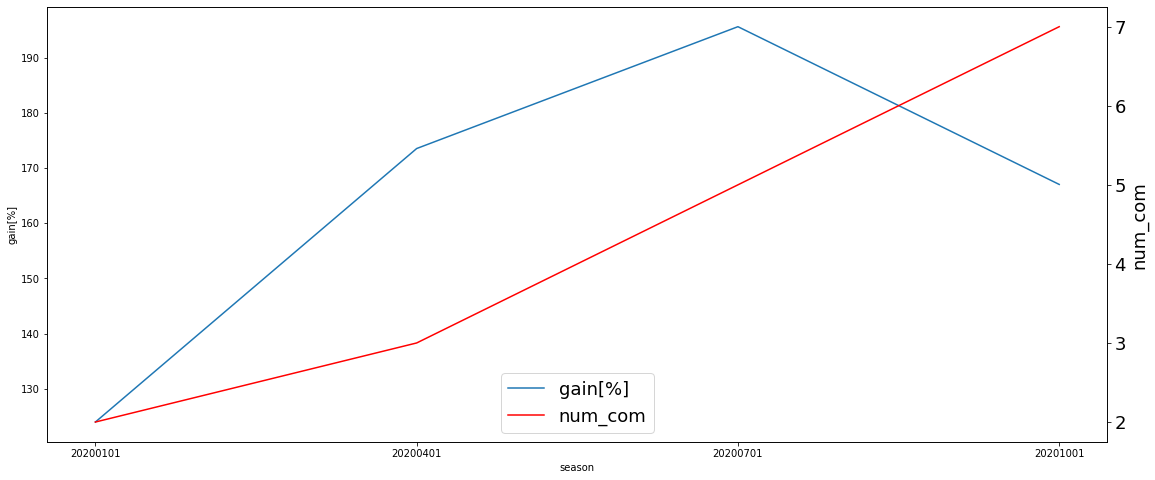

In [13]:
gain_arr=[0]*4
n_com_arr=[0]*4
date_arr=[0]*4
for i in range(4):
    now_ym=datetime.datetime(year=2020, month=1+(i*3),day=1).strftime('%Y%m%d')
    dir_path='csv/use_model_df_{}.csv'.format(now_ym)
    use_models=pd.read_csv(dir_path, encoding='utf_8_sig')
    #display(use_models)
    s_t_use=use_models['total_use_final'].sum()
    s_t_get=use_models['total_get_final'].sum()
    s_gain=(s_t_get/s_t_use)*100
    gain_arr[i]=s_gain
    n_com_arr[i]=len(use_models)
    date_arr[i]=now_ym
x_n='season'
y1_n='gain[%]'
y2_n='num_com'
twin_plt(date_arr,gain_arr,n_com_arr,x_n,y1_n,y2_n)

In [82]:
# # 芦屋だけでひとまず機能を完成させる
# #きめのパラメータ
# place_name='asiya'
# plus_m_th=3
# num_hit_th=5
# version='V4_2'
# mode='asiya_model_score_'
# mode_type='recent'
# csv_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{version}_{mode_type}_TRhit_pM{plus_month}_total_analysis.csv'.format(place_name=place_name,mode_type=mode_type,version=version,plus_month=plus_m_th,num_hit=num_hit_th)
# totol_analysis_df=pd.read_csv(csv_path, encoding='utf_8_sig')
# totol_analysis_df=totol_analysis_df.drop(["Unnamed: 0"],axis=1)

# #閾値の取得
# #th_s=totol_analysis_df[totol_analysis_df['num_plus_com_mean']>3].sort_values('minus_model_per_mean').iloc[0]
# th_s=totol_analysis_df[(totol_analysis_df['num_plus_com_mean']>3) & (totol_analysis_df['num_hit_th']>=10)].sort_values('minus_model_per_mean').iloc[0]
# select_model_df=pd.DataFrame()
# #閾値にあてはまった　モデルたちがどんな奴らなのかを確認する
# for i in range(4):
#     now_ym=datetime.datetime(year=2020, month=1+(i*3),day=1).strftime('%Y%m%d')
#     dir_path='../../bot_database/{place_name}/model_score_{place_name}/v4_score/{version}/{mode}st{now_ym}_finalM3_{version}.csv'.format(place_name=place_name,mode=mode,now_ym=now_ym,version=version)
#     model_score_df=pd.read_csv(dir_path, encoding='utf_8_sig')
#     model_score_df=model_score_df.drop(["Unnamed: 0"],axis=1)
#     #選定したパラメータで切り落とし

    
#     selected_m=model_score_df[model_score_df['gain_test']>=th_s["gain_th"]].copy()
#     selected_m=selected_m[selected_m['gain_std_test']<=th_s["gain_std_th"]].copy()
#     selected_m=selected_m[selected_m['buy_hit_per_test']>=th_s["hit_per_th"]].copy()
#     selected_m=selected_m[selected_m['buy_hit_per_std_test']<=th_s["hit_std_th"]].copy()
#     selected_m=selected_m[selected_m['num_hit_test']>=th_s["num_hit_th"]].copy()#的中した予測の数で切り捨てる,これも可変していく方針に変更した
#     print(now_ym,'=============================================')
#     display(selected_m)
#     select_model_df=pd.concat([select_model_df, selected_m], axis=0)#きめのパラメータで切り落としたので結合
#     #偏差値評価を用いた実際に使用するモデルの切り抜き
#     model_score_df=add_std_score(selected_m)
#     use_models=select_use_model(model_score_df)
#     use_models.to_csv('csv/use_model_df_{}.csv'.format(now_ym))

# #select_model_df.to_csv('check_model2.csv', encoding='utf_8_sig')
# #相関係数の算出（範囲は-1～1）
# #version_corr_df=version_df.corr()

20200101 =============================================


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
8,1.0,5.0,83.0,0.58,46650.0,42400.0,69.0,424.0,110.023585,22.770834,...,24300.0,35.0,243.0,96.666667,28.343074,29.0,11.934156,0.950371,2.0,13.852814
10,1.0,5.0,84.0,0.54,47480.0,47300.0,69.0,473.0,100.380550,19.506249,...,27900.0,35.0,279.0,95.627240,43.304390,31.0,11.111111,1.095000,1.0,33.736264
11,1.0,5.0,84.0,0.58,42380.0,41800.0,69.0,418.0,101.387560,39.832054,...,23900.0,35.0,239.0,94.728033,24.136793,28.0,11.715481,0.870990,2.0,24.428571
13,1.0,5.0,85.0,0.54,47480.0,47000.0,69.0,470.0,101.021277,20.353268,...,27600.0,35.0,276.0,96.666667,44.923817,31.0,11.231884,1.106902,1.0,33.736264
16,1.0,5.0,86.0,0.54,47480.0,46900.0,69.0,469.0,101.236674,20.883301,...,27500.0,35.0,275.0,97.018182,44.849367,31.0,11.272727,1.110927,1.0,33.736264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3423,7.0,7.0,130.0,0.50,24660.0,21900.0,37.0,219.0,112.602740,104.101889,...,15200.0,23.0,152.0,97.894737,30.365012,18.0,11.842105,2.867697,1.0,41.338384
3435,7.0,7.0,134.0,0.50,24660.0,20900.0,37.0,209.0,117.990431,111.260505,...,14600.0,23.0,146.0,95.684932,24.096560,17.0,11.643836,2.593109,1.0,61.277778
3441,7.0,7.0,136.0,0.50,24660.0,20300.0,37.0,203.0,121.477833,115.463778,...,14500.0,23.0,145.0,96.344828,25.697409,17.0,11.724138,2.610992,1.0,61.277778
3444,7.0,7.0,137.0,0.50,24660.0,20100.0,37.0,201.0,122.686567,112.642031,...,14200.0,23.0,142.0,98.380282,27.667274,17.0,11.971831,2.666154,1.0,61.277778


20200401 =============================================


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
3029,7.0,5.0,82.0,0.58,26730.0,25600.0,35.0,256.0,104.414062,120.885407,...,20000.0,30.0,200.0,55.050000,42.966124,8.0,4.000000,0.763763,0.0,380.000000
3031,7.0,5.0,83.0,0.54,35590.0,35300.0,35.0,353.0,100.821530,77.590596,...,24600.0,30.0,246.0,63.333333,30.250395,12.0,4.878049,1.075509,0.0,437.142857
3032,7.0,5.0,83.0,0.58,26730.0,26200.0,35.0,262.0,102.022901,121.104649,...,19500.0,30.0,195.0,56.461538,42.519958,8.0,4.102564,0.783346,0.0,380.000000
3035,7.0,5.0,84.0,0.58,27880.0,25000.0,35.0,250.0,111.520000,119.319197,...,18900.0,30.0,189.0,58.253968,46.921829,8.0,4.232804,0.808214,1.0,380.000000
3036,7.0,5.0,85.0,0.50,43160.0,42700.0,35.0,427.0,101.077283,67.814997,...,27700.0,30.0,277.0,61.696751,29.353683,13.0,4.693141,1.160487,0.0,418.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4383,9.0,7.0,114.0,0.50,34380.0,33800.0,40.0,338.0,101.715976,50.762716,...,21000.0,28.0,210.0,122.380952,94.763838,10.0,4.761905,1.374643,2.0,690.000000
4386,9.0,7.0,115.0,0.50,34380.0,33300.0,40.0,333.0,103.243243,52.933825,...,21100.0,28.0,211.0,118.578199,84.868375,10.0,4.739336,0.986572,1.0,662.000000
4389,9.0,7.0,116.0,0.50,33290.0,32300.0,40.0,323.0,103.065015,55.314810,...,20400.0,28.0,204.0,122.647059,85.063908,10.0,4.901961,1.020425,1.0,662.000000
4395,9.0,7.0,118.0,0.50,31150.0,30800.0,40.0,308.0,101.136364,61.913280,...,19900.0,28.0,199.0,120.100503,98.880722,9.0,4.522613,1.329523,1.0,662.000000


20200701 =============================================


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
133,1.0,5.0,125.0,0.54,28670.0,28500.0,70.0,285.0,100.596491,45.734472,...,17700.0,40.0,177.0,36.101695,24.276980,8.0,4.519774,0.863009,0.0,23.333333
142,1.0,5.0,128.0,0.54,28100.0,27500.0,70.0,275.0,102.181818,45.784653,...,17400.0,40.0,174.0,36.724138,24.643268,8.0,4.597701,0.877888,0.0,23.333333
151,1.0,5.0,131.0,0.54,25320.0,24700.0,70.0,247.0,102.510121,55.371654,...,15500.0,40.0,155.0,41.225806,25.941170,8.0,5.161290,0.985500,0.0,23.333333
157,1.0,5.0,133.0,0.54,22960.0,22800.0,70.0,228.0,100.701754,49.788680,...,14900.0,40.0,149.0,38.724832,33.741390,7.0,4.697987,1.397091,0.0,23.333333
163,1.0,5.0,135.0,0.54,21970.0,21500.0,70.0,215.0,102.186047,45.417378,...,14300.0,40.0,143.0,40.349650,34.263205,7.0,4.895105,1.455710,0.0,23.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6396,13.0,7.0,113.0,0.50,39450.0,27600.0,30.0,276.0,142.934783,127.752725,...,17100.0,19.0,171.0,209.415205,71.696384,6.0,3.508772,0.000000,3.0,0.000000
10847,22.0,7.0,84.0,0.58,36960.0,21600.0,21.0,216.0,171.111111,119.400907,...,13100.0,9.0,131.0,180.534351,213.946816,2.0,1.526718,0.440725,1.0,0.000000
10876,22.0,7.0,94.0,0.54,36960.0,24500.0,21.0,245.0,150.857143,100.125590,...,15200.0,9.0,152.0,155.592105,204.101260,2.0,1.315789,0.379836,1.0,0.000000
10938,22.0,7.0,115.0,0.50,36960.0,23100.0,21.0,231.0,160.000000,115.870158,...,13500.0,9.0,135.0,175.185185,227.370361,2.0,1.481481,0.427667,1.0,0.000000


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

20201001 =============================================


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
125,1.0,5.0,122.0,0.58,23550.0,23400.0,75.0,234.0,100.641026,61.921661,...,12800.0,54.0,128.0,121.562500,44.561024,17.0,13.281250,1.626302,2.0,175.916667
131,1.0,5.0,124.0,0.58,22870.0,21600.0,75.0,216.0,105.879630,65.251087,...,11200.0,54.0,112.0,116.696429,19.243946,15.0,13.392857,1.546474,2.0,71.666667
146,1.0,5.0,129.0,0.58,18060.0,17900.0,75.0,179.0,100.893855,82.890606,...,8300.0,54.0,83.0,96.024096,25.816891,10.0,12.048193,0.695603,1.0,-56.944444
152,1.0,5.0,131.0,0.58,18060.0,17100.0,75.0,171.0,105.614035,81.429849,...,7700.0,54.0,77.0,114.025974,24.973255,11.0,14.285714,0.749806,2.0,-73.611111
155,1.0,5.0,132.0,0.58,16010.0,15700.0,75.0,157.0,101.974522,66.812458,...,6800.0,54.0,68.0,86.764706,8.457148,8.0,11.764706,0.849045,0.0,5.555556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6393,13.0,7.0,112.0,0.50,48740.0,31300.0,37.0,313.0,155.718850,129.088777,...,15300.0,9.0,153.0,161.633987,106.778519,5.0,3.267974,0.377353,2.0,0.000000
6396,13.0,7.0,113.0,0.50,48740.0,31000.0,37.0,310.0,157.225806,127.490843,...,15800.0,9.0,158.0,156.518987,90.561385,5.0,3.164557,0.365412,2.0,0.000000
6405,13.0,7.0,116.0,0.50,48740.0,29700.0,37.0,297.0,164.107744,128.370321,...,15200.0,9.0,152.0,162.697368,102.571092,5.0,3.289474,0.379836,2.0,0.000000
10131,21.0,5.0,98.0,0.50,29970.0,27100.0,19.0,271.0,110.590406,83.467551,...,15400.0,8.0,154.0,47.467532,89.796393,1.0,0.649351,0.374903,1.0,0.000000


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [23]:
th_s

minus_model_per_mean                49.325008
num_plus_com_mean                    3.250000
num_plus_model_mean                 26.250000
gain_th                            100.000000
gain_std_th                        130.000000
hit_per_th                           4.000000
hit_std_th                           1.200000
num_hit_th                          10.000000
st_20200101_minus_per(model)        88.990826
st_20200101_num_plus_com             4.000000
st_20200101_num_plus_model(row)     12.000000
st_20200401_minus_per(model)        18.181818
st_20200401_num_plus_com             2.000000
st_20200401_num_plus_model(row)      9.000000
st_20200701_minus_per(model)         0.000000
st_20200701_num_plus_com             2.000000
st_20200701_num_plus_model(row)     53.000000
st_20201001_minus_per(model)        90.127389
st_20201001_num_plus_com             5.000000
st_20201001_num_plus_model(row)     31.000000
Name: 64413, dtype: float64

## 偏差値評価の機能を作る
=今までの偏差値評価部分との変更点
評価に相関係数を用いることで，finalのgainに関係のあるもの程重みを上げて，総合的な評価を自動的に行えるようにする

total_get_test          0.084398
total_use_test          0.226903
num_com_test            0.046510
num_pred_test           0.226903
gain_test              -0.257171
gain_std_test           0.172104
num_hit_test           -0.028523
buy_hit_per_test       -0.266918
buy_hit_per_std_test   -0.259625
plus_month_num_test     0.030133
diff_mea_med_test      -0.088409
Name: gain_final, dtype: float64

### 相関係数と偏差値を使ったモデル選定

In [79]:
model_score_df=add_std_score(select_model_df)
#model_score_df.to_csv('model_score_df.csv')
use_models=select_use_model(model_score_df)
use_models.to_csv('use_model_df.csv')


c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
c:\users\takuma\nabepy\env\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [44]:
target_com_df.to_csv('model_select.csv')

In [39]:
feature_weights.index

Index(['total_get_test', 'total_use_test', 'num_com_test', 'num_pred_test',
       'gain_test', 'gain_std_test', 'num_hit_test', 'buy_hit_per_test',
       'buy_hit_per_std_test', 'plus_month_num_test', 'diff_mea_med_test'],
      dtype='object')

In [45]:
select_model_df

,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,total_use_final,num_com_final,num_pred_final,gain_final,gain_std_final,num_hit_final,buy_hit_per_final,buy_hit_per_std_final,plus_month_num_final,diff_mea_med_final
8,1.0,5.0,83.0,0.58,46650.0,42400.0,69.0,424.0,110.023585,22.770834,...,24300.0,35.0,243.0,96.666667,28.343074,29.0,11.934156,0.950371,2.0,13.852814
10,1.0,5.0,84.0,0.54,47480.0,47300.0,69.0,473.0,100.380550,19.506249,...,27900.0,35.0,279.0,95.627240,43.304390,31.0,11.111111,1.095000,1.0,33.736264
11,1.0,5.0,84.0,0.58,42380.0,41800.0,69.0,418.0,101.387560,39.832054,...,23900.0,35.0,239.0,94.728033,24.136793,28.0,11.715481,0.870990,2.0,24.428571
13,1.0,5.0,85.0,0.54,47480.0,47000.0,69.0,470.0,101.021277,20.353268,...,27600.0,35.0,276.0,96.666667,44.923817,31.0,11.231884,1.106902,1.0,33.736264
16,1.0,5.0,86.0,0.54,47480.0,46900.0,69.0,469.0,101.236674,20.883301,...,27500.0,35.0,275.0,97.018182,44.849367,31.0,11.272727,1.110927,1.0,33.736264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6393,13.0,7.0,112.0,0.50,48740.0,31300.0,37.0,313.0,155.718850,129.088777,...,15300.0,9.0,153.0,161.633987,106.778519,5.0,3.267974,0.377353,2.0,0.000000
6396,13.0,7.0,113.0,0.50,48740.0,31000.0,37.0,310.0,157.225806,127.490843,...,15800.0,9.0,158.0,156.518987,90.561385,5.0,3.164557,0.365412,2.0,0.000000
6405,13.0,7.0,116.0,0.50,48740.0,29700.0,37.0,297.0,164.107744,128.370321,...,15200.0,9.0,152.0,162.697368,102.571092,5.0,3.289474,0.379836,2.0,0.000000
10131,21.0,5.0,98.0,0.50,29970.0,27100.0,19.0,271.0,110.590406,83.467551,...,15400.0,8.0,154.0,47.467532,89.796393,1.0,0.649351,0.374903,1.0,0.000000


In [74]:
model_score_df

,target_com,depth,target_per,threshold,total_get_test,total_use_test,num_com_test,num_pred_test,gain_test,gain_std_test,...,num_com_test_score,num_pred_test_score,gain_test_score,gain_std_test_score,num_hit_test_score,buy_hit_per_test_score,buy_hit_per_std_test_score,plus_month_num_test_score,diff_mea_med_test_score,score
8,1.0,5.0,83.0,0.58,46650.0,42400.0,69.0,424.0,110.023585,22.770834,...,-0.023632,0.111691,-0.840994,-0.173647,-0.016821,0.105609,0.190622,0.014314,-0.081770,-0.540054
10,1.0,5.0,84.0,0.54,47480.0,47300.0,69.0,473.0,100.380550,19.506249,...,-0.023632,0.207128,0.316931,-0.206044,-0.020937,0.203897,0.204045,0.014314,-0.075015,0.896550
11,1.0,5.0,84.0,0.58,42380.0,41800.0,69.0,418.0,101.387560,39.832054,...,-0.023632,0.100004,0.196011,-0.004334,-0.012704,0.124045,0.084631,0.014314,-0.029135,0.581978
13,1.0,5.0,85.0,0.54,47480.0,47000.0,69.0,470.0,101.021277,20.353268,...,-0.023632,0.201285,0.239993,-0.197638,-0.020937,0.196479,0.202256,0.014314,-0.075015,0.807125
16,1.0,5.0,86.0,0.54,47480.0,46900.0,69.0,469.0,101.236674,20.883301,...,-0.023632,0.199337,0.214129,-0.192378,-0.020937,0.193985,0.201654,0.014314,-0.075015,0.779530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10392,21.0,7.0,101.0,0.50,29970.0,25800.0,19.0,258.0,116.162791,87.913400,...,0.000000,-0.226903,-0.257171,0.172104,0.000000,-0.266918,-0.259625,0.000000,0.000000,-1.065415
10847,22.0,7.0,84.0,0.58,36960.0,21600.0,21.0,216.0,171.111111,119.400907,...,0.000000,-0.250943,-0.293529,0.194918,0.000000,-0.304655,-0.296330,0.045427,0.000000,-1.156055
10876,22.0,7.0,94.0,0.54,36960.0,24500.0,21.0,245.0,150.857143,100.125590,...,0.000000,0.343126,0.381356,-0.255162,0.000000,0.395811,0.384996,-0.027256,0.000000,1.565998
10938,22.0,7.0,115.0,0.50,36960.0,23100.0,21.0,231.0,160.000000,115.870158,...,0.000000,0.056334,0.076706,0.112475,0.000000,0.079613,0.077438,-0.027256,0.000000,0.431644
